
<h1>Traitement du Langage Naturel(NLP) pour l'analyse de sentiments de tweets</h1>





## Import des packages

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC


import contractions
import emoji
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [150]:
df = pd.read_csv("tweet_data.csv")

In [151]:
# Affichage des 10 premières lignes
df.head(10)

,textID,tweet_text,sentiment
0,1956967666,Layin n bed with a headache ughhhh...waitin o...,negative
1,1956967696,Funeral ceremony...gloomy friday...,negative
2,1956967789,wants to hang out with friends SOON!,positive
3,1956968477,Re-pinging @ghostridah14: why didn't you go to...,negative
4,1956968636,Hmmm. http://www.djhero.com/ is down,negative
5,1956969035,@charviray Charlene my love. I miss you,negative
6,1956969172,@kelcouch I'm sorry at least it's Friday?,negative
7,1956969531,Choked on her retainers,negative
8,1956970047,Ugh! I have to beat this stupid song to get to...,negative
9,1956970424,@BrodyJenner if u watch the hills in london u ...,negative


In [152]:
# Le nombre total de tweets
print("Number of tweets: {}".format(len(df)))

Number of tweets: 18727



## Visualization des données

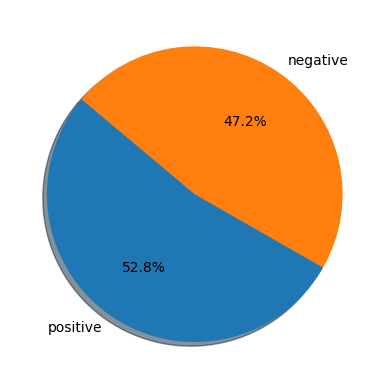

In [153]:
sentiment_count = df["sentiment"].value_counts()
plt.pie(sentiment_count, labels=sentiment_count.index,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

In [154]:

print("Nombre de tweets positifs: {}".format(df[df["sentiment"]=="positive"].count()[0]))
print("Nombre de tweets négatifs: {}".format(df[df["sentiment"]=="negative"].count()[0]))

Nombre de tweets positifs: 9897
Nombre de tweets négatifs: 8830


C:\Users\Admin\AppData\Local\Temp\ipykernel_10456\4155390534.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Nombre de tweets positifs: {}".format(df[df["sentiment"]=="positive"].count()[0]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_10456\4155390534.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Nombre de tweets négatifs: {}".format(df[df["sentiment"]=="negative"].count()[0]))


### Wordclouds des mots les plus fréquents

* Les mots les plus fréquents dans les tweets positifs

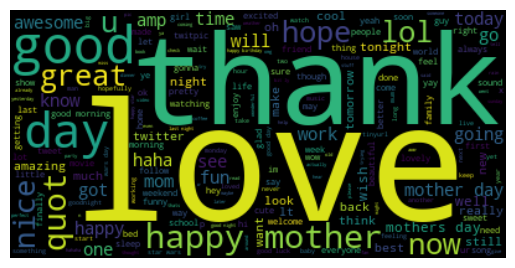

In [155]:
pos_tweets = df[df["sentiment"]=="positive"]
txt = " ".join(tweet.lower() for tweet in pos_tweets["tweet_text"])
wordcloud = WordCloud().generate(txt)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

* Les mots les plus fréquents dans les tweets négatifs

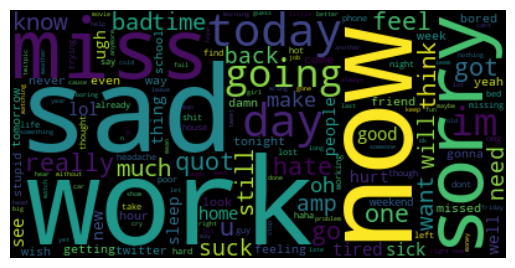

In [156]:
neg_tweets = df[df["sentiment"]=="negative"]
txt = " ".join(tweet.lower() for tweet in neg_tweets["tweet_text"])
wordcloud = WordCloud().generate(txt)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Normalisation du texte

#### Gérer les Tags RT

* Remplacer les occurences `RT` par une valeur par défaut

In [157]:
def replace_retweet(tweet, default_replace=""):
  tweet = re.sub('RT\s+', default_replace, tweet)
  return tweet

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Admin\AppData\Local\Temp\ipykernel_10456\1311733162.py:2: SyntaxWarning: invalid escape sequence '\s'
  tweet = re.sub('RT\s+', default_replace, tweet)


#### Gérer les Tags utilisateurs

* Remplacer `@_Someone_` par un tag utilisateur par défaut

In [158]:
def replace_user(tweet, default_replace="twitteruser"):
  tweet = re.sub('\B@\w+', default_replace, tweet)
  return tweet

<>:2: SyntaxWarning: invalid escape sequence '\B'
<>:2: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Admin\AppData\Local\Temp\ipykernel_10456\1169086728.py:2: SyntaxWarning: invalid escape sequence '\B'
  tweet = re.sub('\B@\w+', default_replace, tweet)


* Remplacer les emojis par leurs significations

In [159]:
def demojize(tweet):
  tweet = emoji.demojize(tweet)
  return tweet

#### Gérer les URLs

* Remplacer les occurences `http://` ou `https://` avec une valeur par défaut

In [160]:
def replace_url(tweet, default_replace=""):
  tweet = re.sub('(http|https):\/\/\S+', default_replace, tweet)
  return tweet

<>:2: SyntaxWarning: invalid escape sequence '\/'
<>:2: SyntaxWarning: invalid escape sequence '\/'
C:\Users\Admin\AppData\Local\Temp\ipykernel_10456\933450514.py:2: SyntaxWarning: invalid escape sequence '\/'
  tweet = re.sub('(http|https):\/\/\S+', default_replace, tweet)


* Remplacer les occurences de `#_something_` avec une valeur par défaut

In [161]:
def replace_hashtag(tweet, default_replace=""):
  tweet = re.sub('#+', default_replace, tweet)
  return tweet

Mettre tout les mots en majuscules 

In [162]:
def to_lowercase(tweet):
  tweet = tweet.lower()
  return tweet

Gérer la repetition des mots

* Remplacer les mots qui se repettent avec une seule occurence ("oooooo" becomes "oo")

In [163]:
def word_repetition(tweet):
  tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
  return tweet

Gérer la répétition des ponctuations

* Remplacer les ponctuations qui se repètes par une seule occurence ("!!!!!" becomes "!")

In [164]:
def punct_repetition(tweet, default_replace=""):
  tweet = re.sub(r'[\?\.\!]+(?=[\?\.\!])', default_replace, tweet)
  return tweet

Gérer les contractions de mots

* Création une fonction `_fix_contractions` utilisée pour remplacer les contractions par leurs formes étendues en utilisant le package contractions

In [165]:
def fix_contractions(tweet):
  tweet = contractions.fix(tweet)
  return tweet


## Tokenization

* Création d'une fonction `tokenize()` qui prend un tweet en entrée et renvoie une liste de tokens

In [166]:
def tokenize(tweet):
  tokens = word_tokenize(tweet)
  return tokens

Tokenisation personnalisée

* Création d'une fonction `custom_tokenize` 

In [167]:
def custom_tokenize(tweet,
                    keep_punct = False,
                    keep_alnum = False,
                    keep_stop = False):
  
  token_list = word_tokenize(tweet)

  # Ignorer les ponctuations
  if not keep_punct:
    token_list = [token for token in token_list
                  if token not in string.punctuation]

  # Ignorer les caractères numériques
  if not keep_alnum:
    token_list = [token for token in token_list if token.isalpha()]
  
  # Ignorer les stopwords
  if not keep_stop:
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')
    token_list = [token for token in token_list if not token in stop_words]

  return token_list

## Stemming

* Création d'une fonction `stem_tokens` qui prend en paramètres une liste de tokens et renvoie une liste de tokens stemmatisés

In [168]:
def stem_tokens(tokens, stemmer):
  token_list = []
  for token in tokens:
    token_list.append(stemmer.stem(token))
  return token_list


## Création d'une grande fonction de preprocessing

* Exemple de tweet a etre prétraité

In [170]:
complex_tweet = r"""RT @AIOutsider : he looooook, 
THis is a big and complex TWeet!!! 👍 ... 
We'd be glad if you couldn't normalize it! 
Check https://t.co/7777 and LET ME KNOW!!! #NLP #Fun"""


* Création d'une fonction `process_tweet` personnalisée qui peut être utilisée pour traiter les tweets de bout en bout


In [171]:
def process_tweet(tweet, verbose=False):
  if verbose: print("Initial tweet: {}".format(tweet))

  ## Twitter Features
  tweet = replace_retweet(tweet) # remplacer les retweets
  tweet = replace_user(tweet, "") # remplacer les users tag
  tweet = replace_url(tweet) # remplacer les urls
  tweet = replace_hashtag(tweet) # remplacer les hashtags

  ## Word Features
  tweet = to_lowercase(tweet) # gérer les majuscules
  tweet = fix_contractions(tweet) # remplaceer les contractions de mots
  tweet = punct_repetition(tweet) # remplacer les répétitions de ponctuations
  tweet = word_repetition(tweet) # remplacer les répétitions de mots
  tweet = demojize(tweet) # remplacer les emojis

  ## Tokenization & Stemming
  tokens = custom_tokenize(tweet, keep_alnum=False, keep_stop=False) # tokenize
  stemmer = SnowballStemmer("english") # definir le stemmer
  stem = stem_tokens(tokens, stemmer) # stematiser les tokens

  return stem

* Tester la fonction `process_tweet` function

In [172]:
print(process_tweet(complex_tweet, verbose=False))

['look', 'big', 'complex', 'tweet', 'would', 'glad', 'could', 'not', 'normal', 'check', 'let', 'know', 'nlp', 'fun']



# Représentation Vectorielle (Bag of Words) </h2>


##  Préprocessing des Tweets

* Appliquer la fonction `process_tweet` créée dans la section 2 à l'ensemble du DataFrame
* Convertir le sentiment en 1 pour un sentiment « positif » et 0 pour un sentiment « négatif »

In [173]:
df["tokens"] = df["tweet_text"].apply(process_tweet)
df["tweet_sentiment"] = df["sentiment"].apply(lambda i: 1
                                              if i == "positive" else 0)
df.head(10)

,textID,tweet_text,sentiment,tokens,tweet_sentiment
0,1956967666,Layin n bed with a headache ughhhh...waitin o...,negative,"[layin, n, bed, headach, call]",0
1,1956967696,Funeral ceremony...gloomy friday...,negative,"[funer, friday]",0
2,1956967789,wants to hang out with friends SOON!,positive,"[want, hang, friend, soon]",1
3,1956968477,Re-pinging @ghostridah14: why didn't you go to...,negative,"[not, go, prom, bf, not, like, friend]",0
4,1956968636,Hmmm. http://www.djhero.com/ is down,negative,[hmm],0
5,1956969035,@charviray Charlene my love. I miss you,negative,"[charlen, love, miss]",0
6,1956969172,@kelcouch I'm sorry at least it's Friday?,negative,"[sorri, least, friday]",0
7,1956969531,Choked on her retainers,negative,"[choke, retain]",0
8,1956970047,Ugh! I have to beat this stupid song to get to...,negative,"[ugh, beat, stupid, song, get, next, rude]",0
9,1956970424,@BrodyJenner if u watch the hills in london u ...,negative,"[watch, hill, london, realis, tourtur, week, w...",0


* Convertir le DataFrame en deux listes : une pour les tokens de tweet (X) et une pour le sentiment du tweet (y)

In [174]:
X = df["tokens"].tolist()
y = df["tweet_sentiment"].tolist()

Fonction de vectorisation des tweets

In [176]:
def fit_cv(tweet_corpus):
  cv_vect = CountVectorizer(tokenizer=lambda x: x,
                            preprocessor=lambda x: x)
  cv_vect.fit(tweet_corpus)
  return cv_vect



# Modélisation par deux modèles de classification (Régression Logistique et SVM Linéaire)

Fonction pour la représentation de la matrice de confusion

In [177]:
import seaborn as sn

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix")
  return sn


## Splitting en données d'entrainement et de test 

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    train_size=0.80)

## Vectorisation des données (Bag of Words)

* Utiliser la fonction `fit_cv` sur les données d'entraînement pour créer le vectoriseur Bag-of-Words
* Transformer ensuite les données X_train et X_test en utilisant le vectoriseur

In [ ]:
cv = fit_cv(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



## Régression Logistic

* Création d'une fonction `fit_lr` utilisée pour ajuster un modèle de régression logistique sur les données X et y *train data*

In [179]:
def fit_lr(X_train, y_train):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  return model

* Ajustement le modèle de régression logistique sur les données d'entraînement en utilisant la fonction `fit_lr`

In [181]:
model_lr = fit_lr(X_train_cv, y_train)


## Metrics de Performance

In [182]:
y_pred_lr = model_lr.predict(X_test_cv)

* Matrice de confusion

<module 'seaborn' from 'c:\\Users\\Admin\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\seaborn\\__init__.py'>

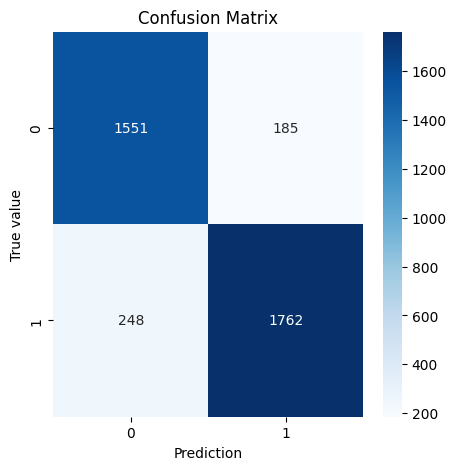

In [196]:
confusion_matrix_lr=confusion_matrix(y_test, y_pred_lr)
plot_confusion(confusion_matrix_lr)

* Accuracy, recall, précision et spécificité du modèle LR

In [197]:
tn = confusion_matrix_lr[1, 1]
fp = confusion_matrix_lr[1, 0]
specificity_lr = tn / (tn + fp)

print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr)))
print("LR Model Precision: {:.2%}".format(precision_score(y_test, y_pred_lr)))
print("LR Model Recall: {:.2%}".format(recall_score(y_test, y_pred_lr)))
print("LR Model Specificity: {:.2%}".format(specificity_lr))


LR Model Accuracy: 88.44%
LR Model Precision: 90.50%
LR Model Recall: 87.66%
LR Model Specificity: 87.66%


## SVM Linéaire

* Création d'une fonction `fit_lr` utilisée pour ajuster un modèle de régression logistique sur les données X et y *train data*

In [188]:
def fit_svm(X_train, y_train):
  model = LinearSVC()
  model.fit(X_train, y_train)
  return model

* Ajustement le modèle svm sur les données d'entraînement en utilisant la fonction `fit_lr`

In [189]:
model_svm = fit_svm(X_train_cv, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



## Metrics de Performance

In [190]:
y_pred_svm = model_svm.predict(X_test_cv)

* Matrice de Confusion

<module 'seaborn' from 'c:\\Users\\Admin\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\seaborn\\__init__.py'>

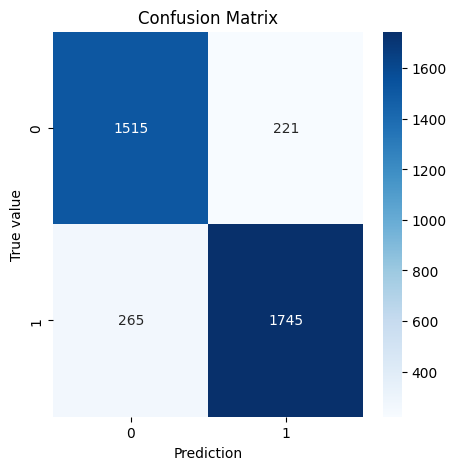

In [200]:
confusion_matrix_svm=confusion_matrix(y_test, y_pred_svm)
plot_confusion(confusion_matrix_svm)

* Accuracy, recall, précision et spécificité du modèle SVM

In [202]:
tn = confusion_matrix_svm[1, 1]
fp = confusion_matrix_svm[1, 0]
specificity_svm = tn / (tn + fp)

print("SVM Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_svm)))
print("SVM Model Precision: {:.2%}".format(precision_score(y_test, y_pred_svm)))
print("SVM Model Recall: {:.2%}".format(recall_score(y_test, y_pred_svm)))
print("SVM Model Specificity: {:.2%}".format(specificity_svm))


SVM Model Accuracy: 87.03%
SVM Model Precision: 88.76%
SVM Model Recall: 86.82%
SVM Model Specificity: 86.82%


* **Commentaire**: La comparaison des performances des deux modèles montre que la Régréssion Logistique offre de meilleures performances sur toute les métriques considérées. 

## Mini-Pipeline de Prédiction


* Exemple de tweet pour tester notre modèle

In [193]:
my_tweet = """RT @AIOutsider: tune in for more amazing NLP content! 
And don't forget to visit https://AIOutsider.com ..."""

* Créer une fonction `predict_tweet` utilisée pour prétraiter, transformer et prédire le sentiment des tweets

In [194]:
def predict_tweet(tweet):
  processed_tweet = process_tweet(tweet)
  transformed_tweet = cv.transform([processed_tweet])
  prediction = model_lr.predict(transformed_tweet)

  if prediction == 1:
    return "Prediction is positive sentiment"
  else:
    return "Prediction is negative sentiment"

* ... Prédiction du sentiment du tweet en utilisant la fonction `predict_tweet` !

In [195]:
predict_tweet(my_tweet)

'Prediction is positive sentiment'